# Sales Forecasting Capstone Project

# -------------------------------
# 1. Introduction
# -------------------------------
# This project aims to forecast item sales across restaurants using machine learning and deep learning.
# We'll explore historical sales data, build predictive models, and compare performance.


In [4]:
%brew install libomp

%pip install xgboost 


==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:40e7f5d7514a7e9757facdd39006f7a351d3d7986d3a228be13c8b1c3216727b
######################################################################### 100.0%  1.4%                                      25.8%          81.6%
==> Pouring portable-ruby-3.4.3.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ab-av1                                   leetgo
adaptivecpp                              libgoa
add-determinism                          libgudev
algolia                                  libpg_query
alloy                                    libpostal-rest
anubis                                   lld@19
anyquery                                 llvm@19
apache

In [15]:
# -------------------------------
# 2. Data Import & Preprocessing
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Synthetic data loading placeholders
restaurants = pd.read_csv('resturants.csv')  

items = pd.read_csv('items.csv')

sales = pd.read_csv('sales.csv')

# Dataset shapes
print(restaurants.shape, items.shape, sales.shape)

# Merge sales with items on item_id and id
sales = sales.merge(items, left_on='item_id', right_on='id', how='left')

# Merge the resulting sales with restaurants on store_id and id
sales = sales.merge(restaurants, left_on='store_id', right_on='id', how='left', suffixes=('', '_store'))

# Select and rename columns for clarity
sales = sales[['date', 'store_id', 'name_store', 'item_id', 'name', 'price', 'item_count', 'kcal', 'cost']]
sales.columns = ['date', 'store_id', 'store_name', 'item_id', 'item_name', 'price', 'item_count', 'kcal', 'cost']

# Convert 'date' column to datetime format
sales['date'] = pd.to_datetime(sales['date'])

# Display the merged dataset
print(sales.head())


(6, 2) (100, 5) (109600, 4)
        date  store_id   store_name  item_id                        item_name  \
0 2019-01-01         1  Bob's Diner        3                Sweet Fruity Cake   
1 2019-01-01         1  Bob's Diner        4  Amazing Steak Dinner with Rolls   
2 2019-01-01         1  Bob's Diner       12             Fantastic Sweet Cola   
3 2019-01-01         1  Bob's Diner       13          Sweet Frozen Soft Drink   
4 2019-01-01         1  Bob's Diner       16             Frozen Milky Smoothy   

   price  item_count  kcal   cost  
0  29.22         2.0   931  29.22  
1  26.42        22.0   763  26.42  
2   4.87         7.0   478   4.87  
3   4.18        12.0   490   4.18  
4   3.21       136.0   284   3.21  


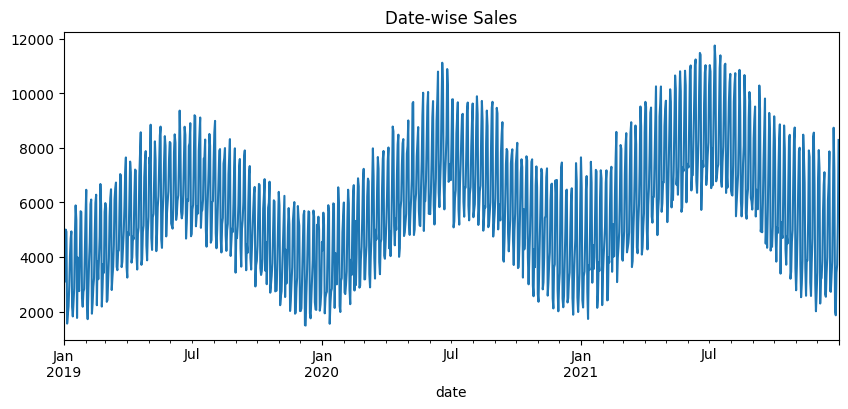

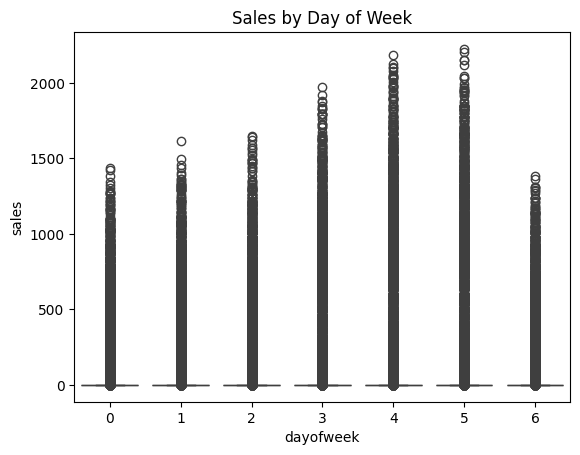

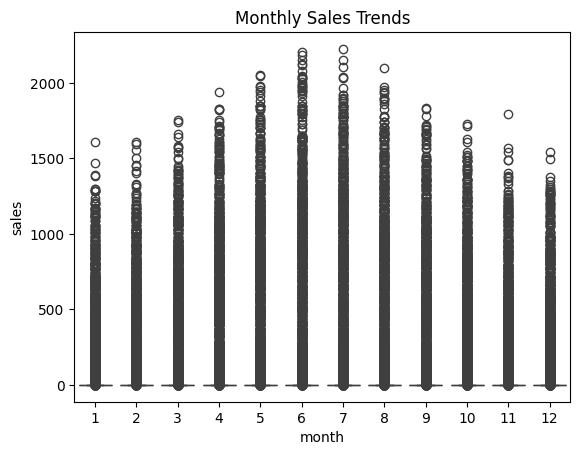

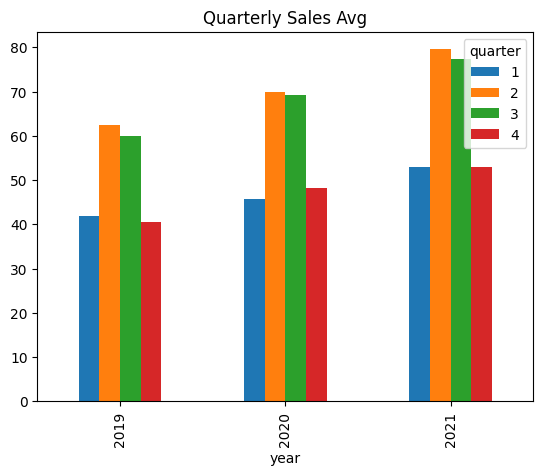

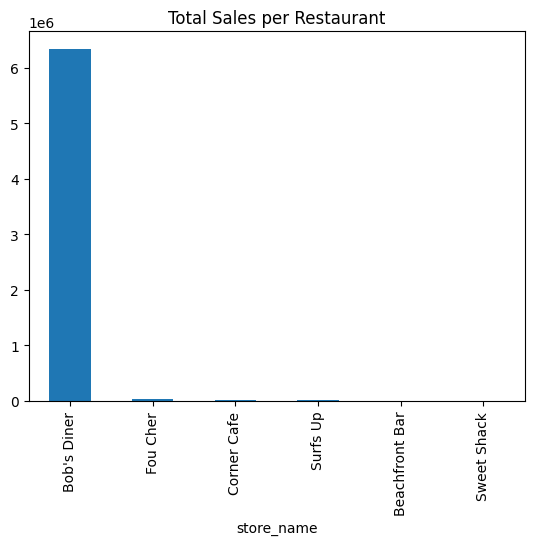

Popular items:
 item_name
Strawberry Smoothy                            236337.0
Frozen Milky Smoothy                          103263.0
Amazing pork lunch                             61043.0
Mutton Dinner                                  52772.0
Orange Juice                                   43874.0
                                                ...   
Original Milky Cake                                0.0
Fantastic Fruity Salmon with Bread meal            0.0
Awesome Fruity Lamb with Vegetables Dinner         0.0
Blue Ribbon Frozen Milky Cake                      0.0
Original Fruity Carrot Cake                        0.0
Name: item_count, Length: 94, dtype: float64
                   Revenue    Volume
store_name                          
Beachfront Bar     3796.20    1305.0
Bob's Diner     6337275.69  687527.0
Corner Cafe       16551.43    1310.0
Fou Cher          27885.37    1106.0
Surfs Up          15651.49    1803.0
Sweet Shack        2578.27    1736.0
Most expensive items with ca

In [16]:
# -------------------------------
# 3. Exploratory Data Analysis
# -------------------------------
sales['sales'] = sales['item_count'] * sales['price']
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['dayofweek'] = sales['date'].dt.dayofweek
sales['quarter'] = sales['date'].dt.quarter

# a. Date-wise sales
sales.groupby('date')['sales'].sum().plot(figsize=(10,4), title='Date-wise Sales')
plt.show()

# b. Weekly pattern
sns.boxplot(x='dayofweek', y='sales', data=sales)
plt.title('Sales by Day of Week')
plt.show()

# c. Monthly trends
sns.boxplot(x='month', y='sales', data=sales)
plt.title('Monthly Sales Trends')
plt.show()

# d. Quarterly pattern
quarter_avg = sales.groupby(['year', 'quarter'])['sales'].mean().unstack()
quarter_avg.plot(kind='bar', title='Quarterly Sales Avg')
plt.show()

# e. Restaurant performance
restaurant_sales = sales.groupby('store_name')['sales'].sum().sort_values(ascending=False)
restaurant_sales.plot(kind='bar', title='Total Sales per Restaurant')
plt.show()

# f. Most popular items
popular_items = sales.groupby('item_name')['item_count'].sum().sort_values(ascending=False)
print("Popular items:\n", popular_items)

# g. Revenue vs volume
store_revenue = sales.groupby('store_name')['sales'].sum()
store_volume = sales.groupby('store_name')['item_count'].sum()
print(pd.DataFrame({'Revenue': store_revenue, 'Volume': store_volume}))

# h. Most expensive items per restaurant
expensive = sales.groupby(['store_name', 'item_name']).agg({'price': 'max', 'kcal': 'mean'})
print("Most expensive items with calories:\n", expensive)


In [17]:
# -------------------------------
# 4. Forecasting with ML Models
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Feature engineering
features = sales[['date', 'sales']].copy()
features['day'] = features['date'].dt.day
features['month'] = features['date'].dt.month
features['year'] = features['date'].dt.year
features['dayofweek'] = features['date'].dt.dayofweek
features['quarter'] = features['date'].dt.quarter

X = features[['day', 'month', 'year', 'dayofweek', 'quarter']]
y = features['sales']

# Train-test split (last 6 months)
split_date = features['date'].max() - pd.DateOffset(months=6)
train = features[features['date'] <= split_date]
test = features[features['date'] > split_date]

X_train = train[['day', 'month', 'year', 'dayofweek', 'quarter']]
y_train = train['sales']
X_test = test[['day', 'month', 'year', 'dayofweek', 'quarter']]
y_test = test['sales']

# Models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f'{name} RMSE: {rmse:.2f}')

LinearRegression RMSE: 237.33
RandomForest RMSE: 236.23
XGBoost RMSE: 236.24


In [18]:
# -------------------------------
# 5. Forecasting with LSTM
# -------------------------------
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Use total sales per day
daily_sales = sales.groupby('date')['sales'].sum().reset_index()
scaler = MinMaxScaler()
daily_sales['scaled_sales'] = scaler.fit_transform(daily_sales[['sales']])

# Create sequence data
def create_sequence(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 10
X_seq, y_seq = create_sequence(daily_sales['scaled_sales'].values, sequence_length)

# Train/test split
split = int(len(X_seq) * 0.8)
X_train_lstm, X_test_lstm = X_seq[:split], X_seq[split:]
y_train_lstm, y_test_lstm = y_seq[:split], y_seq[split:]

# LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm[..., np.newaxis], y_train_lstm, epochs=10, verbose=1)

# Predict and evaluate
preds_lstm = model_lstm.predict(X_test_lstm[..., np.newaxis])
mape = np.mean(np.abs((y_test_lstm - preds_lstm.flatten()) / y_test_lstm)) * 100
print(f"LSTM MAPE: {mape:.2f}%")


Epoch 1/10


/Users/qunxu/Documents/guild/AI/guild_projects/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1788   
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0471
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0294
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0284
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0263
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0212
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM MAPE: 36.94%


/var/folders/9l/kd0gvnp51998_xw_1lzf4nf40000gn/T/ipykernel_5660/3815182634.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start="2019-01-01", periods=36, freq='M')
/var/folders/9l/kd0gvnp51998_xw_1lzf4nf40000gn/T/ipykernel_5660/3815182634.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=3, freq='M')


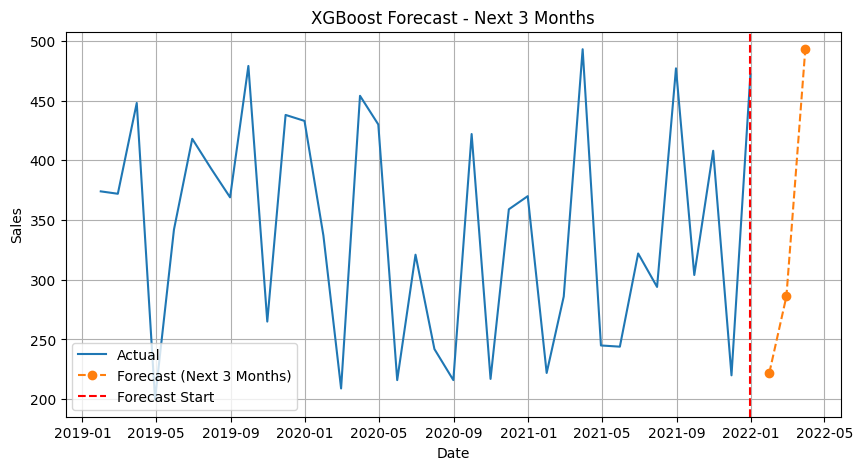

In [25]:
# Forecast Next 3 Months with XGBoost

# Simulated data — replace with your actual dataset
date_range = pd.date_range(start="2019-01-01", periods=36, freq='M')
sales = np.random.randint(200, 500, size=len(date_range))
df = pd.DataFrame({"date": date_range, "sales": sales})

# Feature engineering
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

X = df[['month', 'year']]
y = df['sales']

# Train on full dataset
xgb_model = XGBRegressor()
xgb_model.fit(X, y)

# Forecast next 3 months
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=3, freq='M')
future_df = pd.DataFrame({'date': future_dates})
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year

# Predict
future_df['forecast'] = xgb_model.predict(future_df[['month', 'year']])

# Plot actual + forecast
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['sales'], label="Actual")
plt.plot(future_df['date'], future_df['forecast'], label="Forecast (Next 3 Months)", linestyle='--', marker='o')
plt.axvline(x=last_date, color='red', linestyle='--', label="Forecast Start")
plt.title("XGBoost Forecast - Next 3 Months")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


/var/folders/9l/kd0gvnp51998_xw_1lzf4nf40000gn/T/ipykernel_5660/2943951659.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start="2019-01-01", periods=36, freq='M')
/Users/qunxu/Documents/guild/AI/guild_projects/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/var/folders/9l/kd0gvnp51998_xw_1lzf4nf40000gn/T/ipykernel_5660/2943951659.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=3, freq='M')


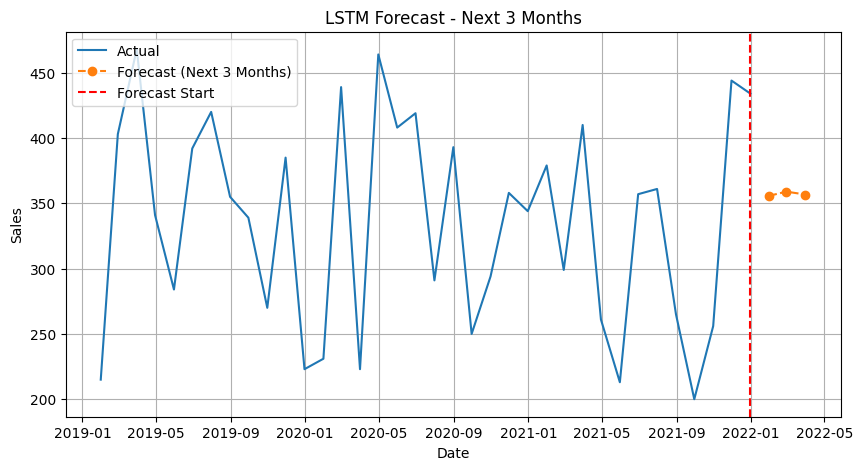

In [27]:
# Forecast Next 3 Months with LSTM

# Simulated data — replace with your actual dataset
date_range = pd.date_range(start="2019-01-01", periods=36, freq='M')
sales = np.random.randint(200, 500, size=len(date_range))
df = pd.DataFrame({"date": date_range, "sales": sales})
df.set_index('date', inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['sales']])

# Prepare LSTM input
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_sequences(scaled_data, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

# Forecast next 3 steps
last_seq = scaled_data[-look_back:].reshape((1, look_back, 1))
predictions = []
for _ in range(3):
    next_pred = model.predict(last_seq)[0]
    predictions.append(next_pred)
    last_seq = np.append(last_seq[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Inverse scale predictions
predicted_sales = scaler.inverse_transform(predictions)

# Build forecast dates
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=3, freq='M')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sales'], label='Actual')
plt.plot(future_dates, predicted_sales.flatten(), label='Forecast (Next 3 Months)', linestyle='--', marker='o')
plt.axvline(x=last_date, color='red', linestyle='--', label="Forecast Start")
plt.title("LSTM Forecast - Next 3 Months")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

